# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The article reports that the dataset represents 17 campaigns that took place between May 2008 and November 2010, with 79534 entries.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [438]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

In [440]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [442]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [445]:
# Let's replace the columns that could have an unknown value with NAN, so that we can do some processing on the data to ensure accuracy.
cols_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']
df[cols_with_unknown] = df[cols_with_unknown].replace('unknown', np.nan)

# To see if there is data that is safe to drop vs replacing, lets take a look at the percentages of nulls in each column
print(df.isnull().sum() / len(df) * 100)

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64


In [447]:
# Restore 'default' missing values back to 'unknown' (we'll handle later)
df['default'] = df['default'].fillna('unknown')

# Drop rows with missing values in other columns (except 'default')
cols_to_check = ['job', 'marital', 'education', 'housing', 'loan']
df = df.dropna(subset=cols_to_check).reset_index(drop=True)

# Final check: Print any remaining missing values
print("Remaining missing values:\n", df.isnull().sum())

Remaining missing values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


Now I want to do some data type enforcement on the data. This will help in making predicitions accurately, efficiently, and also will help with errors we encounter.

In [450]:
# Convert categorical columns to 'category' dtype for memory efficiency and modeling
categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome', 'y'
]
df[categorical_cols] = df[categorical_cols].astype('category')

# Convert numeric columns to proper numeric types (if they aren’t already)
numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

#Duration seems to be a field that isn't relevant to what we are trying to accomplish here, so i'm choosing to drop it since any opportunity to remove features is a win for performance/accuracy
df = df.drop(columns=['duration'])

# Print summary to confirm
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38245 entries, 0 to 38244
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38245 non-null  int64   
 1   job             38245 non-null  category
 2   marital         38245 non-null  category
 3   education       38245 non-null  category
 4   default         38245 non-null  category
 5   housing         38245 non-null  category
 6   loan            38245 non-null  category
 7   contact         38245 non-null  category
 8   month           38245 non-null  category
 9   day_of_week     38245 non-null  category
 10  campaign        38245 non-null  int64   
 11  pdays           38245 non-null  int64   
 12  previous        38245 non-null  int64   
 13  poutcome        38245 non-null  category
 14  emp.var.rate    38245 non-null  float64 
 15  cons.price.idx  38245 non-null  float64 
 16  cons.conf.idx   38245 non-null  float64 
 17  euribor3m   

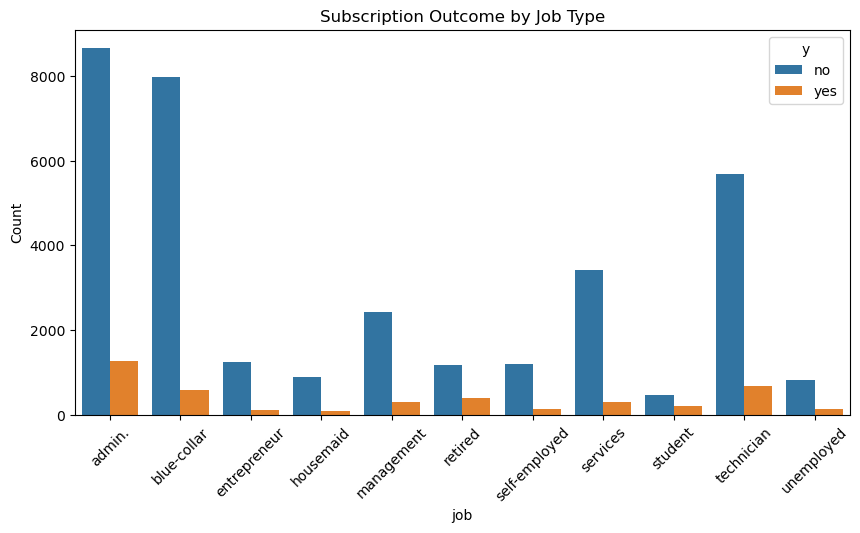

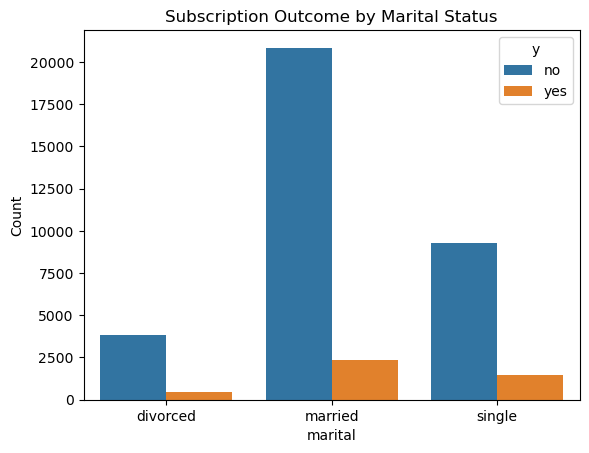

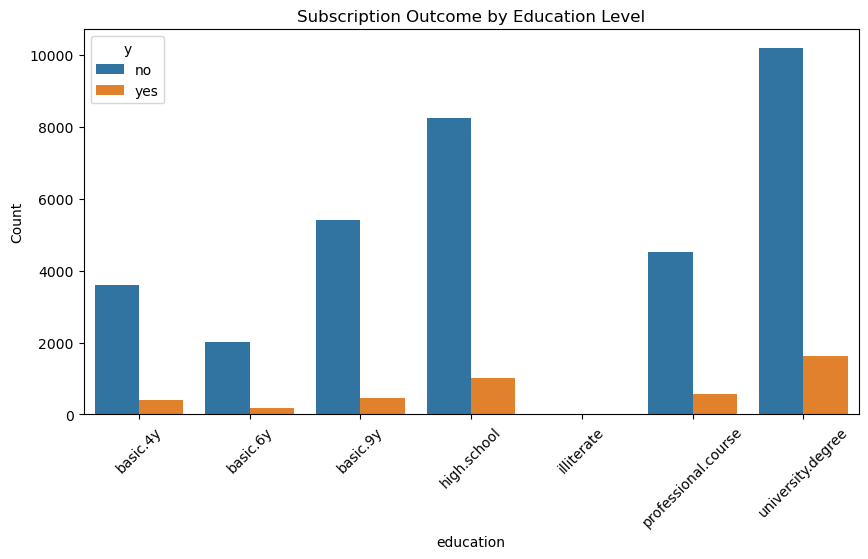

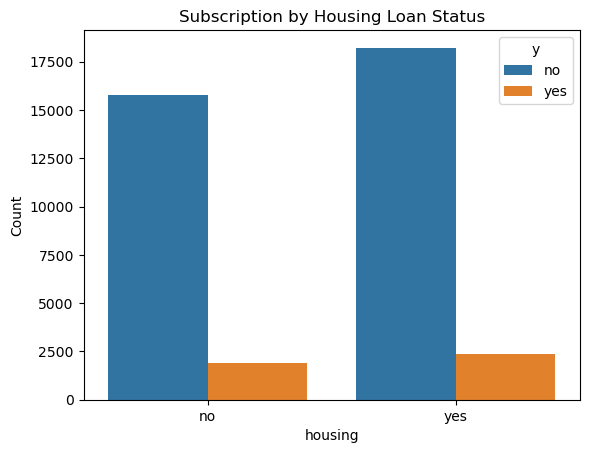

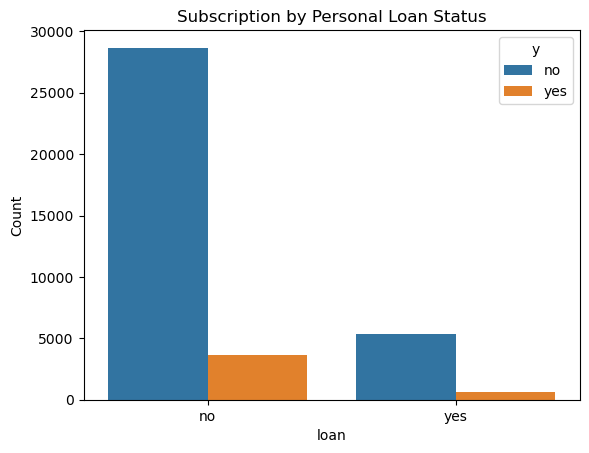

In [452]:
#I also want to take a few features and see how they relate to the decision made by the customer

os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10,5))
sns.countplot(x='job', hue='y', data=df)
plt.title('Subscription Outcome by Job Type')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.savefig('plots/subscription_by_job.png')
plt.show()
plt.close()

sns.countplot(x='marital', hue='y', data=df)
plt.title('Subscription Outcome by Marital Status')
plt.ylabel('Count')
plt.savefig('plots/subscription_by_marital.png')
plt.show()
plt.close()

plt.figure(figsize=(10,5))
sns.countplot(x='education', hue='y', data=df)
plt.title('Subscription Outcome by Education Level')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.savefig('plots/subscription_by_education.png')
plt.show()
plt.close()

sns.countplot(x='housing', hue='y', data=df)
plt.title('Subscription by Housing Loan Status')
plt.ylabel('Count')
plt.savefig('plots/subscription_by_housing.png')
plt.show()
plt.close()

sns.countplot(x='loan', hue='y', data=df)
plt.title('Subscription by Personal Loan Status')
plt.ylabel('Count')
plt.savefig('plots/subscription_by_loan.png')
plt.show()
plt.close()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38245 entries, 0 to 38244
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38245 non-null  int64   
 1   job             38245 non-null  category
 2   marital         38245 non-null  category
 3   education       38245 non-null  category
 4   default         38245 non-null  category
 5   housing         38245 non-null  category
 6   loan            38245 non-null  category
 7   contact         38245 non-null  category
 8   month           38245 non-null  category
 9   day_of_week     38245 non-null  category
 10  campaign        38245 non-null  int64   
 11  pdays           38245 non-null  int64   
 12  previous        38245 non-null  int64   
 13  poutcome        38245 non-null  category
 14  emp.var.rate    38245 non-null  float64 
 15  cons.price.idx  38245 non-null  float64 
 16  cons.conf.idx   38245 non-null  float64 
 17  euribor3m   

The business objective of this project is to predict whether a bank client will subscribe to a term deposit based on their personal, financial, and previous campaign interaction data. By leveraging this predictive model, the bank aims to improve the effectiveness of its marketing campaigns by targeting clients who are more likely to subscribe, thereby increasing conversion rates and reducing operational costs. This data-driven approach enables the bank to optimize customer outreach and allocate resources more efficiently.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [459]:
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
df_model = df[bank_features + ['y']].copy()

In [461]:
X = pd.get_dummies(df_model[bank_features], drop_first=True)

In [476]:
le = LabelEncoder()
y = le.fit_transform(df_model['y'])

print("X shape:", X.shape)
print("y distribution:\n", pd.Series(y).value_counts())

X shape: (38245, 23)
y distribution:
 0    33987
1     4258
Name: count, dtype: int64


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [479]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [482]:
y_test_series = pd.Series(y_test)
value_counts = y_test_series.value_counts(normalize=True)

majority_class_encoded = value_counts.idxmax()
majority_class_label = le.inverse_transform([majority_class_encoded])[0]
majority_accuracy = value_counts.max()

print(f"Majority Class: {majority_class_label}")
print(f"Baseline Accuracy: {round(majority_accuracy, 4)}")

Majority Class: no
Baseline Accuracy: 0.8886


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [491]:
X = df_model[bank_features]
y = LabelEncoder().fit_transform(df_model['y'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

simple_model = Pipeline([
    ('transform', column_trans),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
simple_model.fit(X_train, y_train)
simple_preds = simple_model.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [494]:
accuracy = accuracy_score(y_test, simple_preds)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.5926


In [496]:
# Determine which features are most important
logreg_model = simple_model.named_steps['model']
feature_names = simple_model.named_steps['transform'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg_model.coef_[0]
})

coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoef', ascending=False).drop(columns='AbsCoef')
print(coef_df.head(10).to_string(index=False))

                         Feature  Coefficient
                cat__job_student     1.175752
            cat__default_unknown    -0.862536
                cat__job_retired     0.758620
             cat__marital_single     0.387403
           cat__job_entrepreneur    -0.356181
            cat__job_blue-collar    -0.297496
               cat__job_services    -0.288860
cat__education_university.degree     0.269507
             cat__job_unemployed     0.263688
              cat__job_housemaid    -0.222612


Being a student increases the likelihood of subscription the most! But this seems a bit backwards.. so maybe the later tuning will rectify this.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [377]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

# Store results
results = []

# Fit and evaluate each model
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    results.append({
        "Model": name,
        "Train Time (s)": round(train_time, 4),
        "Train Accuracy": round(train_accuracy, 4),
        "Test Accuracy": round(test_accuracy, 4)
    })

# Create DataFrame for results
comparison_df = pd.DataFrame(results)
print(comparison_df)

                 Model  Train Time (s)  Train Accuracy  Test Accuracy
0  Logistic Regression          0.2094          0.8887         0.8886
1                  KNN          0.0050          0.8938         0.8724
2        Decision Tree          0.0539          0.9148         0.8649
3                  SVM          6.7769          0.8887         0.8886


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [379]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Data Preparation
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
df_model = df[bank_features + ['y']].copy()

# Encode target
y = LabelEncoder().fit_transform(df_model['y'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_model[bank_features], y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

column_trans = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [380]:
baseline_models = {
    "Logistic Regression": Pipeline([
        ('transform', column_trans),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    "KNN": Pipeline([
        ('transform', column_trans),
        ('model', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('transform', column_trans),
        ('model', DecisionTreeClassifier())
    ]),
    "SVM": Pipeline([
        ('transform', column_trans),
        ('model', SVC(probability=True))
    ])
}

baseline_results = []
for name, pipe in baseline_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None

    baseline_results.append({
        'Model': name,
        'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'ROC AUC': round(roc_auc_score(y_test, y_probs), 4) if y_probs is not None else 'N/A'
    })

pre_tuning_df = pd.DataFrame(baseline_results)
pre_tuning_df['Version'] = 'Before Tuning'

print("Baseline Model Performance (Before Tuning):")
print(pre_tuning_df)

Baseline Model Performance (Before Tuning):
                 Model  Test Accuracy  F1 Score  ROC AUC        Version
0  Logistic Regression         0.5926    0.2473   0.6405  Before Tuning
1                  KNN         0.8754    0.0915   0.5711  Before Tuning
2        Decision Tree         0.8653    0.1121   0.5721  Before Tuning
3                  SVM         0.8886    0.0093   0.5490  Before Tuning


In [381]:
from sklearn.model_selection import GridSearchCV

# KNN Tuning
knn_grid = GridSearchCV(
    Pipeline([
        ('transform', column_trans),
        ('model', KNeighborsClassifier())
    ]),
    param_grid={"model__n_neighbors": range(3, 21)},
    cv=5
)
knn_grid.fit(X_train, y_train)
print("Best KNN Params:", knn_grid.best_params_)


Best KNN Params: {'model__n_neighbors': 20}


In [382]:
dt_grid = GridSearchCV(
    Pipeline([
        ('transform', column_trans),
        ('model', DecisionTreeClassifier())
    ]),
    param_grid={"model__max_depth": [3, 5, 10, None], "model__min_samples_split": [2, 5, 10]},
    cv=5
)
dt_grid.fit(X_train, y_train)
print("Best DT Params:", dt_grid.best_params_)

Best DT Params: {'model__max_depth': 3, 'model__min_samples_split': 2}


Baseline Model Performance (After Tuning):
                 Model  Test Accuracy  F1 Score  ROC AUC       Version
0  Logistic Regression         0.5926    0.2473   0.6405  After Tuning
1                  KNN         0.8874    0.0358   0.6116  After Tuning
2        Decision Tree         0.8886    0.0000   0.5963  After Tuning
3                  SVM         0.8886    0.0093   0.5490  After Tuning


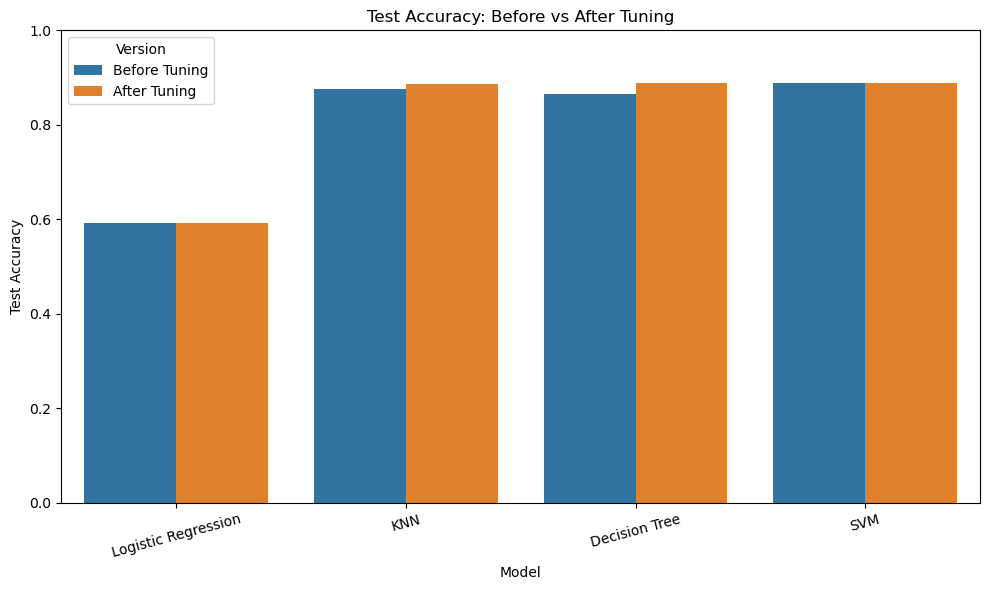

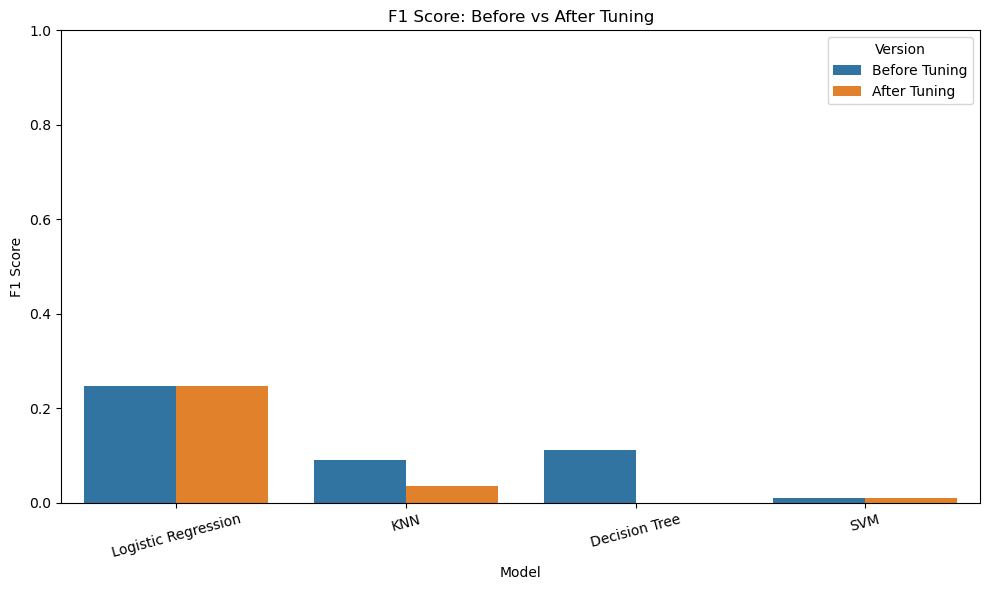

In [383]:
best_knn = knn_grid.best_estimator_
best_dt = dt_grid.best_estimator_

tuned_models = {
    "Logistic Regression": Pipeline([
        ('transform', column_trans),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    "KNN": best_knn,
    "Decision Tree": best_dt,
    "SVM": Pipeline([
        ('transform', column_trans),
        ('model', SVC(probability=True))
    ])
}

tuned_results = []
for name, pipe in tuned_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_probs = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None

    tuned_results.append({
        'Model': name,
        'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1 Score': round(f1_score(y_test, y_pred), 4),
        'ROC AUC': round(roc_auc_score(y_test, y_probs), 4) if y_probs is not None else 'N/A'
    })

post_tuning_df = pd.DataFrame(tuned_results)
post_tuning_df['Version'] = 'After Tuning'

print("Baseline Model Performance (After Tuning):")
print(post_tuning_df)

combined_df = pd.concat([pre_tuning_df, post_tuning_df], ignore_index=True)

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='Model', y='Test Accuracy', hue='Version')
plt.title('Test Accuracy: Before vs After Tuning')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('plots/test_accuracy_comparison.png')
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='Model', y='F1 Score', hue='Version')
plt.title('F1 Score: Before vs After Tuning')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('plots/f1_score_comparison.png')
plt.show()

In evaluating multiple classification models to predict term deposit subscription, we observed that overall accuracy was high across most models, but this came at the cost of poor F1 Scores, particularly due to class imbalance in the dataset.

Logistic Regression maintained consistent performance before and after tuning, with moderate ROC AUC (0.64) and the highest F1 Score (0.2473) — suggesting it was the most balanced in handling both classes, though still far from ideal.

KNN and Decision Tree classifiers improved slightly in accuracy and ROC AUC after tuning but saw a drop in F1 Score, indicating they struggled even more with detecting the minority class.

SVM, despite achieving the highest accuracy (0.8886), had near-zero F1 Score (0.0093), revealing that it predicted only the majority class.

These results highlight the limitations of relying solely on accuracy in imbalanced datasets. Future improvements may involve applying techniques such as class weighting, deailing with oversampling, or threshold adjustments to better capture the minority class ('yes') and improve overall model fairness/usefulness.

This project revealed clear patterns in customer behavior that can guide future marketing strategies. Students, retirees, and university-educated individuals were the most likely to subscribe to term deposits, making them ideal targets for future campaigns. On the other hand, blue-collar workers, housemaids, and entrepreneurs were less responsive, suggesting that marketing to these groups may need to be reconsidered or adjusted.

A significant issue in the dataset was the presence of missing values—especially in the default column—which negatively impacted model performance. Improving data collection to reduce these unknowns would strengthen future predictions. Additionally, the strong class imbalance in the target variable led to misleadingly high accuracy despite low F1 scores, highlighting the need for better class balancing techniques.

While logistic regression offered interpretability, exploring more advanced models like Random Forests or Gradient Boosting could improve predictive power. Including additional features such as call history and economic indicators could also enhance results. With a more robust model, the bank could deploy a system to prioritize outreach and continuously refine targeting as new data becomes available.

##### Questions

Why are F1 scores so low despite high accuracy?
What other features could improve the model?
Are there ethical or fairness concerns in who we're targeting or excluding?